# 1. Setup


In [ ]:
!pip install labelme tensorflow tensorflow-gpu albumentations matplotlib opencv-python

In [6]:
import os,time,uuid,cv2

IMAGES_PATH = os.path.join('data','images','images')
number_images = 30

In [8]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [9]:
!labelme

[INFO   ] __init__:get_config:70 - Loading config file from: C:\Users\mehmu\.labelmerc
2022-08-10T09:30:21.920ZE [35928:ShellIpcClient] shell_ipc_client.cc:129:Connect Can't connect to socket at: \\.\Pipe\GoogleDriveFSPipe_mehmu_shell
2022-08-10T09:30:21.924ZE [35928:ShellIpcClient] shell_ipc_client.cc:602:operator() Failed to connect to the server: Status::UNAVAILABLE_RESOURCE
2022-08-10T09:30:21.924ZE [35928:ShellIpcClient] shell_ipc_client.cc:129:Connect Can't connect to socket at: \\.\Pipe\GoogleDriveFSPipe_mehmu_shell
2022-08-10T09:30:21.924ZE [35928:ShellIpcClient] shell_ipc_client.cc:602:operator() Failed to connect to the server: Status::UNAVAILABLE_RESOURCE
2022-08-10T09:30:21.924ZE [2940:ShellIpcClient] shell_ipc_client.cc:129:Connect Can't connect to socket at: \\.\Pipe\GoogleDriveFSPipe_mehmu_shell
2022-08-10T09:30:21.924ZE [2940:ShellIpcClient] shell_ipc_client.cc:602:operator() Failed to connect to the server: Status::UNAVAILABLE_RESOURCE
2022-08-10T09:30:21.924ZE [35928:

# 2. Loading Images 

In [14]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import json
import warnings
warnings.filterwarnings("ignore")

In [15]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [16]:
images=tf.data.Dataset.list_files('data/images/images/*.jpg',shuffle=False)

In [17]:
def load_img(x):
    byte=tf.io.read_file(x)
    img=tf.io.decode_jpeg(byte)
    return img

In [18]:
images=images.map(load_img)
images.as_numpy_iterator().next()

array([[[134, 145, 129],
        [136, 147, 131],
        [134, 145, 129],
        ...,
        [175, 193, 205],
        [176, 194, 208],
        [177, 195, 209]],

       [[133, 144, 128],
        [135, 146, 130],
        [137, 148, 132],
        ...,
        [176, 194, 206],
        [174, 192, 204],
        [171, 189, 201]],

       [[136, 147, 133],
        [137, 148, 134],
        [139, 150, 136],
        ...,
        [175, 195, 204],
        [174, 192, 202],
        [171, 189, 199]],

       ...,

       [[110, 112, 101],
        [107, 109,  98],
        [106, 108,  97],
        ...,
        [118, 130, 130],
        [116, 126, 125],
        [118, 128, 127]],

       [[107, 110,  99],
        [103, 106,  95],
        [103, 105,  92],
        ...,
        [115, 127, 127],
        [111, 121, 122],
        [112, 122, 123]],

       [[ 99, 102,  91],
        [ 97, 100,  89],
        [100, 102,  89],
        ...,
        [114, 126, 126],
        [110, 120, 121],
        [110, 120, 121]]

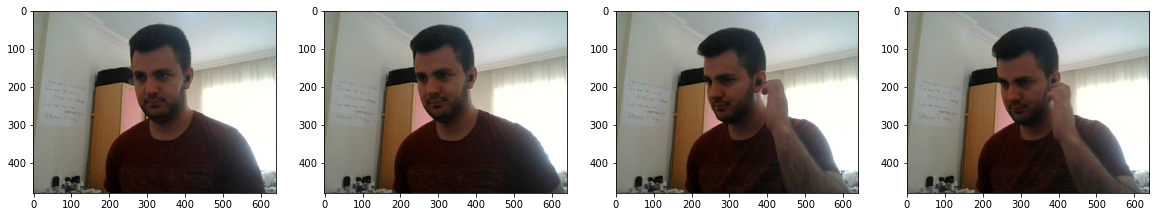

In [19]:
img_gen=images.batch(4).as_numpy_iterator()
plot_img=img_gen.next()

fig,ax=plt.subplots(ncols=4,figsize=(20,20))
for idx,image in enumerate(plot_img):
    ax[idx].imshow(image)
plt.show()

In [32]:
import splitfolders

splitfolders.ratio("data/images", output="data", seed=1337, ratio=(.7, .2, .1))
for i in ['val','train','test']:
    os.mkdir(f'data/{i}/labels')


Copying files: 60 files [00:00, 986.26 files/s]


In [33]:
import shutil
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            shutil.copyfile(existing_filepath, new_filepath)      

# 3. Augmentation

In [37]:
import albumentations as alb

augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                        alb.HorizontalFlip(p=0.5), 
                        alb.RandomBrightnessContrast(p=0.2),
                        alb.RandomGamma(p=0.2), 
                        alb.RGBShift(p=0.2), 
                        alb.VerticalFlip(p=0.5)], 
                        bbox_params=alb.BboxParams(format='albumentations', label_fields=['class_labels']))

In [38]:
img = cv2.imread(os.path.join('data','train', 'images','00cb37ad-188f-11ed-b62e-38fc98c566e1.jpg'))

with open(os.path.join('data', 'train', 'labels', '00cb37ad-188f-11ed-b62e-38fc98c566e1.json'), 'r') as f:
    label = json.load(f)
label['shapes'][0]['points']

[[204.74358974358972, 42.05128205128205], [398.0769230769231, 300.0]]

In [39]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]
coords

[204.74358974358972, 42.05128205128205, 398.0769230769231, 300.0]

In [40]:
coords = list(np.divide(coords, [640,480,640,480]))
coords

[0.3199118589743589, 0.0876068376068376, 0.6219951923076923, 0.625]

In [ ]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

cv2.rectangle(augmented['image'], 
                tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
                tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                (255,0,0), 2)

plt.imshow(augmented['image'])

In [43]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]      # default annotation for images which doesn't involve face
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):         #augment per image
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

x_max is less than or equal to x_min for bbox [0.8864182692307694, 0.4829059829059829, 0.6115785256410257, 0.007478632478632479, 'face'].


In [44]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_img)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_img)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_img)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [45]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

In [46]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))


test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [48]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(2640, 2640, 900, 900, 960, 960)

In [49]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(4000)
train = train.batch(8)
train = train.prefetch(4)

test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [53]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.4011 , 0.425  , 0.8604 , 0.899  ],
        [0.1555 , 0.02348, 0.633  , 0.6777 ],
        [0.4006 , 0.4585 , 0.7617 , 0.948  ],
        [0.204  , 0.09644, 0.663  , 0.5703 ],
        [0.2303 , 0.09375, 0.6177 , 0.438  ],
        [0.2568 , 0.4133 , 0.713  , 0.9556 ],
        [0.2617 , 0.11743, 0.6353 , 0.612  ],
        [0.582  , 0.03995, 1.     , 0.6255 ]], dtype=float16))

# 4. Model

In [54]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

vgg = VGG16(include_top=False)

vgg.summary()

58889256/58889256 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

In [55]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [56]:
facetracker = build_model()

facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [57]:
X, y = train.as_numpy_iterator().next()
X.shape

(8, 120, 120, 3)

In [59]:
classes, coords = facetracker.predict(X)
classes, coords

1/1 [==============================] - 0s 16ms/step


(array([[0.5047153 ],
        [0.5865984 ],
        [0.44800746],
        [0.56857115],
        [0.5687237 ],
        [0.47608608],
        [0.48509568],
        [0.6032403 ]], dtype=float32),
 array([[0.6776905 , 0.5104358 , 0.5455367 , 0.48616922],
        [0.59167457, 0.39703757, 0.48335105, 0.4252255 ],
        [0.6686212 , 0.5237302 , 0.5138301 , 0.43615538],
        [0.62472045, 0.53399074, 0.5086854 , 0.45709953],
        [0.5520417 , 0.46677294, 0.52163625, 0.5043961 ],
        [0.69241685, 0.47457874, 0.5575399 , 0.48629904],
        [0.6311384 , 0.5408095 , 0.55313367, 0.5275881 ],
        [0.603303  , 0.42795712, 0.5850496 , 0.45710742]], dtype=float32))

In [60]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

In [61]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [69]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=5.162139>

In [70]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.64001423>

In [71]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=5.162139>

In [62]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [63]:
model = FaceTracker(facetracker)
model.compile(opt, classloss, regressloss)

In [72]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
330/330 [==============================] - 20s 53ms/step - total_loss: 3.8498e-04 - class_loss: 7.6081e-09 - regress_loss: 3.8497e-04 - val_total_loss: 12.9045 - val_class_loss: 15.2492 - val_regress_loss: 5.2799
Epoch 2/10
330/330 [==============================] - 20s 55ms/step - total_loss: 3.9101e-04 - class_loss: 7.1580e-09 - regress_loss: 3.9101e-04 - val_total_loss: 13.7524 - val_class_loss: 15.2492 - val_regress_loss: 6.1278
Epoch 3/10
330/330 [==============================] - 21s 58ms/step - total_loss: 3.9059e-04 - class_loss: 5.8974e-09 - regress_loss: 3.9059e-04 - val_total_loss: 13.4199 - val_class_loss: 15.2492 - val_regress_loss: 5.7953
Epoch 4/10
330/330 [==============================] - 22s 60ms/step - total_loss: 3.6897e-04 - class_loss: 5.9425e-09 - regress_loss: 3.6897e-04 - val_total_loss: 12.9291 - val_class_loss: 15.2492 - val_regress_loss: 5.3045
Epoch 5/10
330/330 [==============================] - 22s 61ms/step - total_loss: 3.8449e-04 - class_los

In [ ]:
test_data = test.as_numpy_iterator()

test_sample = test_data.next()

yhat = facetracker.predict(test_sample[0])

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                        tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                        tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

In [79]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 16ms/step


In [80]:
from tensorflow.keras.models import load_model

facetracker.save('facetracker.h5')
facetracker = load_model('facetracker.h5')